In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('Fraud_Detection_Dataset.csv', delimiter=',', on_bad_lines='skip')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        298

In [3]:
df.fillna(0, inplace=True)

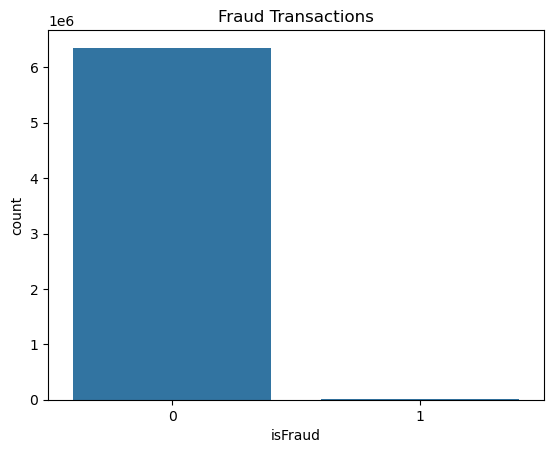

In [4]:
sns.countplot(x=df['isFraud'])
plt.title('Fraud Transactions')
plt.show()

In [20]:
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['newbalanceOrig'] = pd.to_numeric(df['newbalanceOrig'], errors='coerce')
df['type'] = df['type'].astype('category').cat.codes

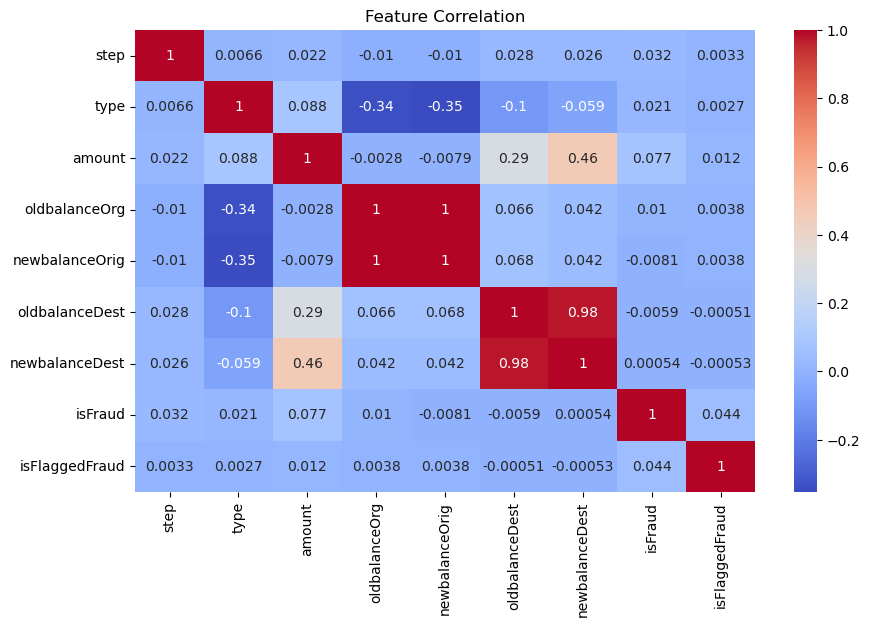

In [21]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [22]:
df['balanceOrigChange'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDestChange'] = df['oldbalanceDest'] - df['newbalanceDest']

In [23]:
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest'])
y = df['isFraud']

In [24]:
encoder = LabelEncoder()
X['type'] = encoder.fit_transform(X['type'])

In [25]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [29]:
X_resampled = X_resampled.sample(n=10000, random_state=42)
y_resampled = y_resampled.loc[X_resampled.index]
print("Resampled dataset shape:", X_resampled.shape, y_resampled.shape)

Resampled dataset shape: (10000, 10) (10000,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

In [31]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                             tree_method='hist', n_estimators=50, verbosity=0),
    "LightGBM": LGBMClassifier(n_estimators=50, n_jobs=-1)
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Confusion Matrix for {name}:\n", confusion_matrix(y_test, y_pred))
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    print(f"AUC-ROC Score for {name}: ", roc_auc_score(y_test, y_pred))


Training Logistic Regression...
Confusion Matrix for Logistic Regression:
 [[950  40]
 [ 98 912]]
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       990
           1       0.96      0.90      0.93      1010

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

AUC-ROC Score for Logistic Regression:  0.9312831283128312

Training Random Forest...
Confusion Matrix for Random Forest:
 [[ 978   12]
 [   6 1004]]
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       990
           1       0.99      0.99      0.99      1010

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

AUC-ROC

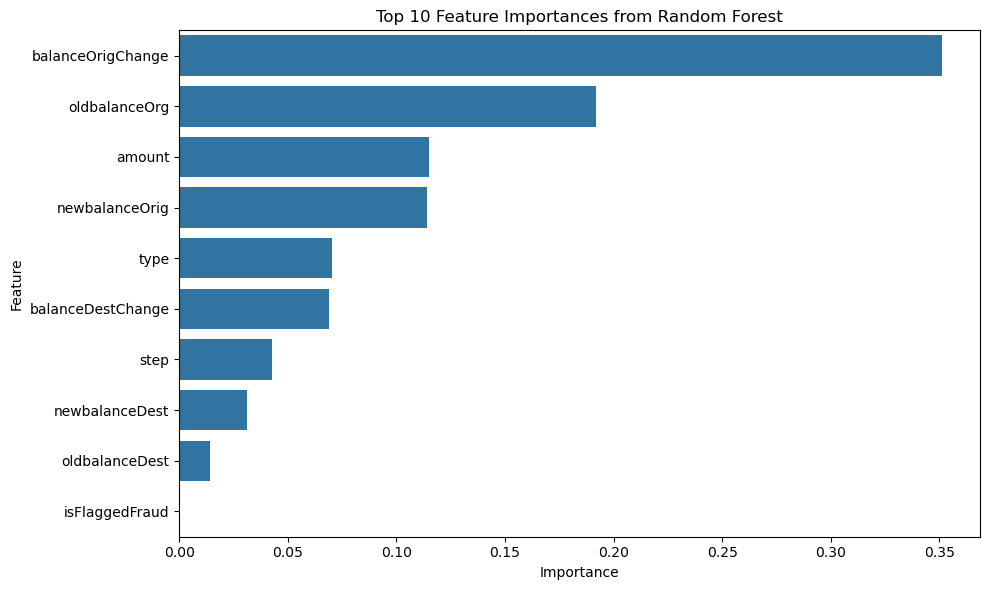

In [32]:
importances = models["Random Forest"].feature_importances_
feature_names = X_train.columns

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(10))
plt.title("Top 10 Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

In [33]:
import joblib

joblib.dump(models["Random Forest"], "fraud_model.pkl")


['fraud_model.pkl']